In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
def convertToInt(table):
    for i in range(len(table)):
        for j in range(len(table[i])):
            table[i][j] = table[i][j][1]

In [6]:
data = pd.read_csv("dataset.csv")
dataset = data.iloc[:, :-1]
x = data.iloc[:, -1:]
for column in dataset:
    dataset[column] = pd.to_numeric(dataset[column], downcast='float')
convertToInt(x.values)
x['Class'] = x['Class'].astype(str).astype(int)
x

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Class
0,1
1,1
2,1
3,1
4,1
...,...
101,2
102,2
103,2
104,2


In [7]:
def minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        value_min = dataset[:, i].min()
        value_max = dataset[:, i].max()
        minmax.append([value_min, value_max])
    return minmax


def normalize(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (float)(row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [8]:
min_max = minmax(dataset.values)
normalize(dataset.values, min_max)
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,0.265957,0.097087,0.442105,0.451923,0.211538,0.884615,0.961538,0.403846,0.346154
1,0.202128,0.126214,0.421053,0.423077,0.048077,0.538462,0.038462,0.413462,0.250000
2,0.382979,0.893204,0.336842,0.913462,0.096154,0.317308,0.711538,0.663462,0.634615
3,0.680851,0.621359,0.421053,0.980769,0.500000,0.153846,0.750000,0.740385,0.759615
4,0.372340,0.601942,0.252632,0.990385,0.663462,0.980769,0.798077,0.932692,0.528846


In [9]:
dataset.shape

(106, 9)

In [10]:
def manhattan(a, b):
    d = 0
    for i in range(len(a)):
        d += abs(a[i] - b[i])
    return d


def euclide(a, b):
    d = 0
    for i in range(len(a)):
        d += (a[i] - b[i]) ** 2
    return d ** 0.5


def chebyshev(a, b):
    d = -1
    for i in range(len(a)):
        d = max(d, abs(a[i] - b[i]))
    return d


def uniform(v):
    if abs(v) < 1:
        return 0.5
    return 0


def triangular(v):
    if abs(v) < 1:
        return 1 - abs(v)
    return 0


def epanechnikov(v):
    if abs(v) < 1:
        return 3 / 4 * (1 - v ** 2)
    return 0


def quartic(v):
    if abs(v) < 1:
        return 15 / 16 * (1 - v ** 2) ** 2
    return 0


def triweight(v):
    if abs(v) < 1:
        return 35 / 32 * (1 - v ** 2) ** 3
    return 0


def tricube(v):
    if abs(v) < 1:
        return ((1 - abs(v) ** 3) ** 3) * 70 / 81
    return 0


def gaussian(v):
    return (math.e ** (-0.5 * (v ** 2))) / math.sqrt(2 * math.pi)


def cosine(v):
    if abs(v) < 1:
        return (math.pi / 4) * math.cos((math.pi / 2) * v)
    return 0


def logistic(v):
    return 1 / (math.exp(v) + 2 + math.exp(-v))


def sigmoid(v):
    return (2 / math.pi) / (math.exp(v) + math.exp(-v))


functions = {
    "uniform": uniform,
    "triangular": triangular,
    "quartic": quartic,
    "epanechnikov": epanechnikov,
    "triweight": triweight,
    "tricube": tricube,
    "gaussian": gaussian,
    "cosine": cosine,
    "logistic": logistic,
    "sigmoid": sigmoid
}

distances = {
    "manhattan": manhattan,
    "euclidean": euclide,
    "chebyshev": chebyshev
}

windows = ['fixed', 'variable']


In [11]:
def getPrediction(dType, kType, wType, h, params, x, query):
    distance_function = distances[dType]
    kernel_function = functions[kType]
    window = wType
    eps = 1e-5
    vectorDistances = [(distance_function(params[i], query), x[i]) for i in range(len(x))]
    vectorDistances = sorted(vectorDistances)

    divisor = h if window == "fixed" else vectorDistances[h][0]

    sum_x = 0
    sum_y = 0
    super_sum = 0
    if divisor == 0:
        for i in vectorDistances:
            if i[0] == 0:
                sum_x += 1
                sum_y += i[1]
    else:
        for cur in vectorDistances:
            v = cur[0] / divisor
            k = kernel_function(v)
            sum_x += k
            sum_y += cur[1] * k
    if sum_x < 0.0001:
        return sum(x) / len(x)
    else:
        
        return sum_y / sum_x

In [12]:
def get_gar(a, b):
    return 0 if a + b == 0 else (2 * a * b) / (a + b)

def getF_score(c): 
    k = len(c)
    total = [0 for i in range(k)]
    All = 0
    for i in range(k):
        total[i] = sum(c[i])
        All += total[i]

    TP = [0 for i in range(k)]
    for i in range(k):
        TP[i] = c[i][i]

    FP = [0 for i in range(k)]
    for i in range(k):
        for j in range(k):
            if i != j:
                FP[i] += c[i][j]

    FN = [0 for i in range(k)]
    for i in range(k):
        for j in range(k):
            if i != j:
                FN[j] += c[i][j]

    recall = [0.0 for i in range(k)]
    precision = [0.0 for i in range(k)]
    for i in range(k):
        recall[i] = 0 if FP[i] + TP[i] == 0 else TP[i] / (TP[i] + FP[i])
        precision[i] = 0 if FN[i] + TP[i] == 0 else TP[i] / (TP[i] + FN[i])

    microAns = 0
    for i in range(k):
        microAns += get_gar(precision[i], recall[i]) * total[i]

    return microAns / All

In [13]:
def get_one_hots(t):
    oneHotArr = [[0 for j in range(len(t))] for i in range(4)]
    for i in range(len(t)):
        oneHotArr[t[i]][i] = 1
    return oneHotArr

In [14]:
def F_score_table(dType, fType, wType, h, isOneHot):
    table = [[0 for j in range(4)]  for i in range(4)]
    X = x.values
    X_numbers = [(int(i) - 1) for i in X]
    for i in range(dataset.shape[0]):
        another_x = X_numbers[0: i] + X_numbers[i+1 : len(X_numbers)]
        query = dataset.iloc[i].values.tolist()
        another_y = dataset.drop(i).values.tolist()
        if isOneHot:
            oneHotTable = get_one_hots(another_x)
            maximum = 0.0
            ind = 0
            for j in range(len(oneHotTable)):
                predict = getPrediction(dType, fType, wType, h, another_y, oneHotTable[j], query)
                if (predict > maximum):
                    maximum = predict
                    ind = j
            table[X_numbers[i]][ind] += 1
        else:
            predict = round(getPrediction(dType, fType, wType, h, another_y, another_x, query))
            table[X_numbers[i]][predict] += 1
    return getF_score(table)
    

In [17]:
def all_variants(isOneHot):
    my_time = time.time()
    maxim = 0
    distance_type = ""
    function_type = ""
    windows_type = ""
    h_final = 0
    for dType in distances.keys():
        for fType in functions.keys():
            for wType in windows:
                #print(dType, fType, wType, ":")
                cur_ans = 0
                cur_h = 0
                if (wType == "fixed"):
                    for h in range(1, dataset.shape[0] - 1):
                        t = F_score_table(dType, fType, wType, h / 10, isOneHot)
                        if (t > cur_ans):
                            cur_ans = t
                            cur_h = h
                else:
                    for h in range(0, 29):
                        t = F_score_table(dType, fType, wType, h, isOneHot)
                        if (t > cur_ans):
                            cur_ans = t
                            cur_h = h
                if (maxim < cur_ans):
                    maxim = cur_ans
                    distance_type = dType
                    function_type = fType
                    windows_type = wType
                    h_final = cur_h
                print(dType, fType, wType, cur_h, cur_ans)
    print(time.time() - my_time)
    return (distance_type, function_type, windows_type, h_final, maxim)

In [18]:
ans = all_variants(0)

manhattan uniform fixed 16 0.479492362982929
manhattan uniform variable 1 0.5282516934833075
manhattan triangular fixed 19 0.5270732635235842
manhattan triangular variable 1 0.5282516934833075
manhattan quartic fixed 19 0.5291949141005745
manhattan quartic variable 1 0.531298562713657
manhattan epanechnikov fixed 19 0.5193480760127139
manhattan epanechnikov variable 1 0.5282516934833075
manhattan triweight fixed 20 0.5540873309883302
manhattan triweight variable 6 0.5206363506253548
manhattan tricube fixed 20 0.5378535402268757
manhattan tricube variable 3 0.5203651802545752
manhattan gaussian fixed 5 0.5084585060751893
manhattan gaussian variable 0 0.25560735415878444
manhattan cosine fixed 19 0.5283290751426516
manhattan cosine variable 1 0.5282516934833075
manhattan logistic fixed 2 0.4342534127161944
manhattan logistic variable 0 0.14402023692718235
manhattan sigmoid fixed 2 0.4342534127161944
manhattan sigmoid variable 0 0.14402023692718235
euclidean uniform fixed 7 0.437183642153

In [20]:
ans_oneHot = all_variants(1)

manhattan uniform fixed 19 0.632006804737264
manhattan uniform variable 3 0.6346071769061925
manhattan triangular fixed 19 0.6285229789043137
manhattan triangular variable 9 0.6327262619672174
manhattan quartic fixed 20 0.6470435857678384
manhattan quartic variable 12 0.6460342417889587
manhattan epanechnikov fixed 19 0.6268472722585197
manhattan epanechnikov variable 5 0.6409144546872653
manhattan triweight fixed 22 0.6203709836377304
manhattan triweight variable 14 0.6406255227945599
manhattan tricube fixed 21 0.6381946754270457
manhattan tricube variable 14 0.6477825173752463
manhattan gaussian fixed 6 0.6108213395717846
manhattan gaussian variable 0 0.41287465057371836
manhattan cosine fixed 19 0.6372192361340361
manhattan cosine variable 4 0.639196425723698
manhattan logistic fixed 2 0.6024825328247883
manhattan logistic variable 1 0.29227023737066343
manhattan sigmoid fixed 3 0.6127886229997538
manhattan sigmoid variable 0 0.33540396710208026
euclidean uniform fixed 8 0.536411784

In [19]:
def get_ans(answer, oneHot):
    print(answer)
    drawer = []
    arr = []
    if (answer[2] == "fixed"):
        for h in range(1, 60):
            arr.append(h / 10)
            drawer.append(F_score_table(answer[0], answer[1], answer[2], h / 10, oneHot))
    else:
        for h in range(0, dataset.shape[0] - 1):
            arr.append(h)
            drawer.append(F_score_table(answer[0], answer[1], answer[2], h, oneHot))
    plt.plot(arr, drawer)

('manhattan', 'triweight', 'fixed', 20, 0.5540873309883302)


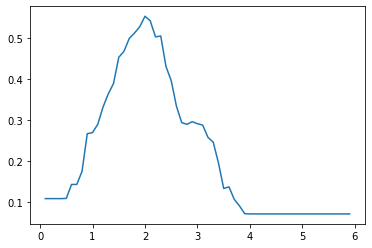

In [20]:
get_ans(ans, 0)

('manhattan', 'tricube', 'variable', 14, 0.6477825173752463)


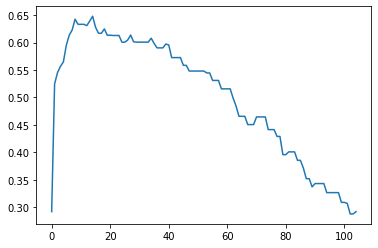

In [23]:
get_ans(ans_oneHot, 1)